In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
inp=np.load("input16.npz")
out=np.load("output16.npz")

In [27]:
inp2=inp['arr_0']
inp1=inp['arr_1']

In [28]:
out1=out['arr_0']

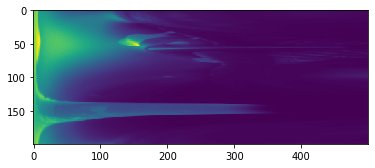

In [31]:
plt.imshow(inp1[199].astype(np.int))

In [32]:
MAX_WORDS = 500  # シーケンスの最大長
torch.manual_seed(0)
train_batch_size =  64  # 訓練時のバッチサイズ
test_batch_size = 1000  # テスト時のバッチサイズ
epochs = 5  # 学習回数
device = 'cuda'  # GPUで学習するならcudaにする
lr = .01  # 学習率

In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    inp1, out1, test_size=0.1, random_state=0
    )

In [34]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(12870, 200, 500) (12870, 2)
(1430, 200, 500) (1430, 2)


In [35]:
class WDataset(Dataset):
    def __init__(self, dinp, dout):
        self.dinp = dinp
        self.dout = dout

    def __len__(self):
        return len(self.dinp)

    def __getitem__(self, idx):
        dinp = self.dinp[idx] 
        dout = self.dout[idx]
        sample = {
            'inp': dinp.astype(np.float32),
            'out': dout.astype(np.float32)
            }
        return sample

In [36]:
train_loader = DataLoader(
    WDataset(X_train, y_train),
    batch_size=train_batch_size,
    shuffle=True,
    num_workers=4
    )
test_loader = DataLoader(
    WDataset(X_test, y_test),
    batch_size=test_batch_size,
    shuffle=True,
    num_workers=4
    )

In [37]:
train_dataset = WDataset(X_train, y_train)
print(train_dataset[0])

{'inp': array([[179., 176., 175., ...,  21.,  21.,  22.],
       [179., 176., 175., ...,  20.,  20.,  20.],
       [179., 176., 175., ...,  19.,  19.,  20.],
       ...,
       [179., 176., 175., ...,  21.,  22.,  22.],
       [179., 176., 175., ...,  23.,  23.,  23.],
       [179., 176., 175., ...,  23.,  23.,  23.]], dtype=float32), 'out': array([0., 0.], dtype=float32)}


In [38]:
train_dataset[0:10]['inp'].shape

(10, 200, 500)

In [39]:
class Net1D(nn.Module):
    def __init__(self):
        super(Net1D,self).__init__()

        self.conv1 = nn.Conv1d(200, 500,kernel_size=3, stride=1)
        self.bn1 = nn.BatchNorm1d(500)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2)

        self.conv2 = nn.Conv1d(500, 300,kernel_size=3, stride=1)
        self.bn2 = nn.BatchNorm1d(300)
        self.conv3 = nn.Conv1d(300,64,kernel_size=3, stride=1)
        self.gap = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(64,2)


    def forward(self,x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.conv3(x)
        x = self.gap(x)
        x = x.view(x.size(0),-1)
        x = self.fc(x)

        return x

In [40]:
def train(model, device, train_loader, optimizer, epoch, log_interval=100):
    model.train()
    for batch_idx, batch_sample in enumerate(train_loader):
        inps = batch_sample['inp']
        outs = batch_sample['out']
        inps, outs = inps.to(device), outs.to(device)
        optimizer.zero_grad()  # オプティマイザの初期化
        output = model(inps)  # 予測
        loss = criterion(output, outs)  # 損失の計算
        loss.backward()  # 勾配の計算
        optimizer.step()  # パラメータの更新
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(inps), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

# テスト
def test(model, device, test_loader):
    model.eval()
    test_loss = 0.
    with torch.no_grad():
        for batch_sample in test_loader:
            inps = batch_sample['inp']
            outs = batch_sample['out']
            inps, outs = inps.to(device), outs.to(device)
            output = model(inps)  # 予測
            test_loss += criterion(output, outs)  # 損失計算
    print('\nTest set: Average loss: {:.4f}\n'.format(test_loss))

In [41]:
model = Net1D()

model = model.to(device)
criterion = nn.MSELoss()  # 最小二乗誤差を損失関数に設定
optimizer = optim.Adam(model.parameters(), lr=lr)  # オプティマイザはAdamを設定
for epoch in range(1, epochs + 1):  # 指定したエポック分，訓練とテストを繰り返す
    train(model, device, train_loader, optimizer, epoch)  # 訓練
    test(model, device, test_loader)  # テスト
torch.save(model.state_dict(), './weight.pth')  # 学習したモデルの保存

Train Epoch: 1 [0/12870 (0%)]	Loss: 0.042895
Train Epoch: 1 [6400/12870 (50%)]	Loss: 0.040719
Train Epoch: 1 [12800/12870 (99%)]	Loss: 0.039268

Test set: Average loss: 0.0659

Train Epoch: 2 [0/12870 (0%)]	Loss: 0.066776
Train Epoch: 2 [6400/12870 (50%)]	Loss: 0.017956
Train Epoch: 2 [12800/12870 (99%)]	Loss: 0.057332

Test set: Average loss: 0.0682

Train Epoch: 3 [0/12870 (0%)]	Loss: 0.033505
Train Epoch: 3 [6400/12870 (50%)]	Loss: 0.022626
Train Epoch: 3 [12800/12870 (99%)]	Loss: 0.033883

Test set: Average loss: 0.0634

Train Epoch: 4 [0/12870 (0%)]	Loss: 0.033632
Train Epoch: 4 [6400/12870 (50%)]	Loss: 0.029880
Train Epoch: 4 [12800/12870 (99%)]	Loss: 0.044594

Test set: Average loss: 0.0664

Train Epoch: 5 [0/12870 (0%)]	Loss: 0.023014
Train Epoch: 5 [6400/12870 (50%)]	Loss: 0.030130
Train Epoch: 5 [12800/12870 (99%)]	Loss: 0.025037

Test set: Average loss: 0.0724



In [42]:
model.eval()
test_loss = 0.
with torch.no_grad():
    for batch_sample in test_loader:
        inps = batch_sample['inp']
        outs = batch_sample['out']
        inps, outs = inps.to(device), outs.to(device)
        output = model(inps)  # 予測
        test_loss += criterion(output, outs)  # 損失計算

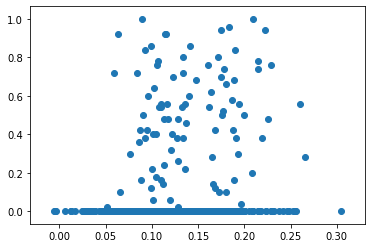

In [43]:
d0=output.data.cpu().numpy()
d1=outs.data.cpu().numpy()

plt.scatter(d0,d1)

In [44]:
outs

tensor([[0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.6802, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.4800],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.4